# Fig.21 Eddington ratio 4-panel plots 

This code is taken from `../code2/Trends_SFinf_Eddington_ratio.ipynb` - I correct the y-label... 

In [14]:
from scipy.stats import binned_statistic_2d
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import os
import pandas as pd
import healpy as hp
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
from scipy.stats import binned_statistic as bs 
from scipy.stats import binned_statistic_2d
import linmix
from scipy.optimize import minimize
from scipy import optimize
from astroML.linear_model import TLS_logL

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



In [11]:

def make_fEdd_sfInf_plot(data_, source = 'chelsea',
    seg = 'sdss', remove_lowN = True ,  Nmin  = 5, useTLS = False, 
    uselinmix = False, offset = None, ):
    '''  Code to plot Mi vs MBH,  colored by fEdd (first panel),  
    SFinf (second panel),  and object count (third panel). Fourth 
    panel is the median SFinf vs median fEdd (crosses). These
    are averaged in bins along fEdd, whose width is defined 
    so that there is an equal number of points per bin. 
    
    '''
    # any pre-selection from the data 
    # all points from s82drw_ugriz_shen2011_shen2008.txt
    # fulfil this criteria - so no need to add a selection...
    #m2 = data_['Plike'] - data_['Pnoise'] > 2 
    #m3 = data_['Plike'] - data_['Pinf'] > 0.05 
    #m4 = data_['edge'] == 0 
    #m = m2&m3&m4
    #print(np.sum(m),'/', len(m))
    #data = data_[m].copy()
    data = data_.copy()

    # plotted quantities : 
    # absolute i-band magnitude K-corr to z=2 
    MI = data['MI_Z2'] # Shen2011 

    # redshift  : Shen2011 
    z =  data['REDSHIFT']

    # black hole mass from Shen+2011
    MBH = data['LOGBH']

    # Eddington ratio : Shen2011
    # log(L/LEdd ) = log( L / 1.26e38 MBH / Msun)

    logEddRatio = data['LOGEDD_RATIO'] # Shen2011
    #logEddRatio = qso['LOGLBOL'] - np.log10(1.5) - 38 - qso['LOGBH']  # Shen 2011 but with 
    # Chlsea's definition of LEdd (1.5 rather than 1.26 )
    #logEddRatio = qso['Lbol'] - np.log10(1.5) - 38 - qso['mass_BH_1']  # shen 2008

    if source == 'chelsea' : 
        #sf4000 = sfinf * np.power(4000 / lambdaRF, -0.479 ) # B = -0.479 for SFinf 
        sf4000 = data['SFinf4000']
        
    if source == 'celerite':
        lambdaobs = 6250 # angstroms  - since these are the results for 
        # combined SDSS r-band, centered on 6250 Angstroms 
        lambdaRF = lambdaobs /  (1.+z)

        #tauRF = data['tauEXP_'+seg] / (1.+z)  # shift to rest frame 
        #tau4000 = tauRF * np.power(4000/lambdaRF, 0.17) # B=0.17 for tau

        sfinf = data['sigmaEXP_'+seg] * np.sqrt(2) # no need to shift anything 
        sf4000 = sfinf * np.power(4000 / lambdaRF, -0.479 ) # B=-0.497 for SFinf
        
        
    # initialize plotting space 
    fig,axs = plt.subplots(1,4, figsize=(22,5))
    ax = np.ravel(axs)

    # plot settings 
    cmap = 'cubehelix' # the colormap 
    gridsize = 15  # the grid size for binned_statistic_2d()

    # set the extent of plot boundaries 
    # ext0 is for log(MBH) - log(MI) : panels 1,2,3
    # ext1 is for log(SFinf) - log(fEdd) : panel 4 
    if seg == 'sdss-ps1':
        extent0 = [7,11, -23,-29]
        extent1 = [-2.6,0.6, -1.2,-0.4]
        #extent1 = [-2.6,0.6, -1.2,-0.2]

    if seg == 'sdss':
        extent0 = [7,11, -23,-29]
        extent1 = [-2.6,0.6, -1.4,-0.4]


    ################################################
    # left panel : find log10( median logEddRatio  per bin ) 
    # all panels have identical x,y grid, 
    # with different z values - 
    # thus use the X,Y meshgrid from here for all
    # plotting
    ################################################

    iax = 0 
    # set bottom and height for both colorbars
    bottom, height =  1.03, 0.02

    xmin, xmax = extent0[0],extent0[1]
    ymin, ymax = extent0[3],extent0[2]

    if remove_lowN : 
        # find the count of bins in the MBH,  MI  grid. 
        # obly consider bins above the count of Nmin ... 
        stats_count =  binned_statistic_2d(MBH, MI, MI, 
                                 statistic='count', bins=gridsize, 
                                 range = [[xmin,xmax], [ymin,ymax]])

        mcount = stats_count[0].T < Nmin

    EddRatio = np.power(10,logEddRatio)
    stats_fEdd = binned_statistic_2d(MBH, MI, EddRatio, 
                             statistic='median', bins=gridsize, 
                             range = [[xmin,xmax], [ymin,ymax]])

    H, xedges, yedges = stats_fEdd[0].T, stats_fEdd[1], stats_fEdd[2]
    if remove_lowN : 
        H[mcount] = np.nan  # replace the bins with low count with nans  
                            # - as if they were empty 
    X,Y = np.meshgrid(xedges, yedges)

    # also, find the same grid but offset by 1/2 binwidth, 
    # to allow for marking with 'x'  cells that fulfill a certain criterion
    dX = xedges[1]-xedges[0]
    XC = X+dX/2 # bin centers 

    dY = yedges[1]-yedges[0]
    YC = Y+dY/2  # bin centers 

    # make an image spanning 2D statistic H  on  X,Y meshgrid 
    image = ax[iax].pcolormesh(X, Y, np.log10(H), cmap=cmap)

    # get left and right coordinates in figure units 
    # for left axis 
    l,b,w,h = ax[iax].get_position().bounds
    cax = fig.add_axes([l,bottom,w,height])
    plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
                 label=r'$\log_{10}{(L_{bol} / L_{Edd} )}$')

    ################################################
    # middle panel : find log10( median SF_inf  per bin) 
    ################################################
    iax = 1 

    # I first find the aggregates, and then the plotted quantity 
    # I need that so that I would have the median 
    # of f_Edd,  rather the median of log(f_Edd), as done above...

    # for plotting , use median of logarthmic bins ...
    stats_sf4000 =  binned_statistic_2d(MBH, MI, sf4000, 
                             statistic='median', bins=gridsize, 
                            range = [[xmin,xmax], [ymin,ymax]])
    H = stats_sf4000[0].T
    if remove_lowN : 
        H[mcount] = np.nan 

    image = ax[iax].pcolormesh(X,Y,np.log10(H) , cmap=cmap)

    # get left and right coordinates in figure units 
    # for middle axis 
    l,b,w,h = ax[iax].get_position().bounds
    cax = fig.add_axes([l,bottom,w,height])
    plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
                 label=r'$\log_{10}{(SF_{\infty})}$')


    ################################################
    # third panel : plot the count of Number of quasars 
    # per bin of M_i vs M_BH ... 
    ################################################
    iax = 2

    # for plotting , use the count per bin 
    stats_count =  binned_statistic_2d(MBH, MI, MI, 
                             statistic='count', bins=gridsize, 
                             range = [[xmin,xmax], [ymin,ymax]])
    H = stats_count[0].T
    if remove_lowN : 
        H[mcount] = np.nan 

    image = ax[iax].pcolormesh(X,Y,np.log10(H) , cmap=cmap)

    l,b,w,h = ax[iax].get_position().bounds
    cax = fig.add_axes([l,bottom,w,height])
    plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
                 label=r'$\log_{10}{(count})}$')

    # invert axis and add labels to panels 1:3 
    for iax in range(3):
        ax[iax].invert_yaxis()
        ax[iax].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
        ax[iax].set_ylabel(r'$M_{i}$')

    ################################################
    # fourth panel : plot the log(median(f_Edd))  vs log (median(SF_inf ))
    ################################################
    iax = 3

    x = np.log10(stats_fEdd[0].T)
    y = np.log10(stats_sf4000[0].T)

    # ensure that we only use the points within plot limits 

    # plot all used points 
    ax[iax].plot(x,y, 'k.')

    ax[iax].set_xlim(extent1[0], extent1[1] )
    ax[iax].set_ylim(extent1[2], extent1[3])
    ax[iax].set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
    ax[iax].set_xlabel(r'$\log_{10}{(L_{bol} / L_{Edd})}$')

    # replace nans with very low values beyond the plot bounds 
    #x[np.where(np.isnan(x))] = -100
    #y[np.where(np.isnan(y))] = -100


    # can't do that because that would change the shape of x,y ... 
    # select only those that are within plot bounds 
    #mx = (extent1[0] < x) & (x < extent1[1])
    #my = (extent1[2] < y) & (y < extent1[3])

    
    # Here we define what are the outlier points, 
    # and whether to remove them before binning,
    # or not 
    
    # whether to remove outliers 
    remove_outliers  = True 

    # whether to mark bins where points in the right panel 
    # fulfil certain criteria
    mark_bins = False

    # whether to remove outliers according to Chelsea's Fig.15, or 
    # only the lower left corner 
    chelsea_outliers = False 
    low_left_outliers = False 

    if chelsea_outliers: 
        # this removes points below or above lines where Chelsea doesn't 
        # have anything on her plot ....

        # two points defining upper line 
        A = [-1.75, -0.4] 
        B = [ 0.5,-0.9]
        #/ y1 = a*x1 + b
        #\ y2 = a*x2 + b 
        # 
        # b = y1 - a*x1 ,  so   y2  = a*x2 + y1 - a*x1  ,  thus 
        # y2 - y1 = a * (x2 - x1) , so a   = (y2-y1) / (x2-x1)
        # and b = y1 - a * x1 

        a = (B[1]-A[1]) / (B[0] - A[0])
        b = A[1] - a*A[0]

        mupper = y > ( a*x + b )
        xp = np.sort(x.flatten())
        # shade the area above the upper line 
        ax[iax].fill_between(xp, a*xp+b, -0.4,
                         facecolor='green',  alpha=0.1)

        # two points defining lower line 
        A = [-2.5, -0.6] 
        B = [-1.25, -1.4]
        a = (B[1]-A[1]) / (B[0] - A[0])
        b = A[1] - a*A[0]

        mlower = y < ( a*x + b )
        # shade the area below the lower line 
        ax[iax].fill_between(xp, a*xp+b, -1.4,
                         facecolor='green',  alpha=0.1)

        moutlier = mupper | mlower 

    if low_left_outliers : 
        # this removes the triangle in the bottom-left, 
        moutlier = (x<-1) & (y<-1.2)

    if remove_lowN : 
        moutlier = mcount 

    sel  = np.where(moutlier == True)

    # plot those as red dots 
    ax[iax].plot(x[sel],y[sel], 'r.')

    # mark the bins from which they came on the other panels 
    if mark_bins : 
        for iax in range(3):
            ax[iax].scatter(XC[sel], YC[sel], marker='x', s=40,c='red')

    # flatten the x,y, arrays,  keeping only the points within plot boundaries for 
    # fitting...
    # and / or  removing the 'outliers' 
    mx = (extent1[0] < x) & (x < extent1[1])
    my = (extent1[2] < y) & (y < extent1[3])


    if remove_outliers : 
        msel = mx & my & ~moutlier 
    else :
        msel = mx & my 

    xf = x[msel].flatten()
    yf = y[msel].flatten()

    iax = 3
    ax[iax].plot(xf,yf, 'gx')


    # for  kept points, divide into 10 bins along log(fEdd),
    # so that each bin has equal number of points .... 

    def histedges_equalN(x, nbin):
        npt = len(x)
        return np.interp(np.linspace(0, npt, nbin + 1),
                         np.arange(npt), np.sort(x))

    bin_edges  = histedges_equalN(xf, 10)
    bin_widths = np.diff(bin_edges)
    # plot vertical lines to illustrate non-uniform bin boundaries 
    # for edge in bin_edges : 
    #     ax[1].axvline(edge)
    #bin_centers  =  (bin_edges[1:] + bin_edges[:-1] ) /2.
    stat_med, bin_edges1,  binnumber = bs(xf,yf,statistic='median', bins=bin_edges)
    bin_centers1 = (bin_edges1[1:] + bin_edges1[:-1] ) /2.


    # get the count per bin
    stat_count, bin_edges1,  binnumber = bs(xf,xf,statistic='count', bins=bin_edges)

    N = stat_count

    # get the RMS, estimated by sigmaG,  per bin 
    sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))
    stat_RMS, bin_edges1,  binnumber = bs(xf,yf,statistic=sigmaG, bins=bin_edges)

    sigma_median = 1.25 * stat_RMS / np.sqrt(N)

    ax[iax].errorbar(bin_centers1, stat_med, sigma_median, fmt='o', 
                     mec = 'black', mfc='white',
                ecolor = 'black', capthick=2,
               markersize=10, )
    # markeredgecolor or mec
    # markeredgewidth or mew
    # markerfacecolor or mfc
    # ecolor specifies the color of errorbar(s) 

    # fit with the straight line 
    sy = sigma_median  * np.ones_like(stat_med)

    # here 1 is the order of the polynomial : y = ax + b
    z = np.polyfit(bin_centers1, stat_med,1, w = 1 / sy)
    a_fit_poly,  b_fit_poly  = z 
    print('POLYFIT  slope a = ', a_fit_poly)
    # use poly1 object for plotting the straight line 
    p1 = np.poly1d(z) 
    xmin, xmax = ax[iax].get_xlim()
    xp = np.linspace(xmin,xmax,1000)
    ax[iax].plot(xp, p1(xp), lw=3, ls='-', c='orange', label='fit')
    # this is equivalent to defining a fitting function and providing it 
    # with sigma_y  for curve_fit()

    # redefine variables to make fitting easier 
    x,y,ysig =  bin_centers1, stat_med, sy
    xsig =  ( 1. / np.sqrt(12) )  * bin_widths

    if uselinmix : 
        print('Finding the slope with LinMix ...')
        lm1 = linmix.LinMix(x=x, y=y, xsig=xsig, ysig=ysig, K=3)
        lm1.run_mcmc(silent=True)
        
        # store the MCMC chains 
        np.save('fEdd_SFinf_'+source+'_Shen2011_'+seg+'_gridsize_'+\
                str(gridsize)+'_sqr_limN_linmix_chain', lm1.chain[:])

        a = lm1.chain[:]['alpha']
        alpha1 = np.mean(a)
        alpha1_err = np.std(a)

        b = lm1.chain[:]['beta']
        beta1 = np.mean(b)
        beta1_err = np.std(b)

        print('alpha = ', alpha1, ' +/- ', alpha1_err)
        print('beta = ', beta1, ' +/- ', beta1_err)

    if useTLS : 
        print('Finding the slope with AstroML TLS implementation...')
        X = np.vstack((x, y)).T
        dX = np.zeros((len(x), 2, 2))
        dX[:, 0, 0] = xsig ** 2
        dX[:, 1, 1] = ysig ** 2
        dX[:, 0, 1] = dX[:, 1, 0] = 0 # no cross-covariance ... 

        min_func = lambda beta: -TLS_logL(beta, X, dX)
        beta_fit = optimize.fmin(min_func, x0=[-1, 1])
        print(beta_fit)
        def get_m_b(beta):
            b = np.dot(beta, beta) / beta[1]
            m = -beta[0] / beta[1]
            return m, b

        slope, offset  = get_m_b(beta_fit)
        print('A=', offset, 'C=', slope)

    # plot Chelsea's slope...
    slope, dslope = -0.23, 0.03
    if not offset : 
        offset = -1.03
    ax[iax].plot(xp, slope*xp + offset, lw=3, ls='--', c='magenta',  label='M10')
    
    # shade the limits of the slope 
#     ax[iax].fill_between(xp, 
#                          (slope-dslope)*xp + offset, 
#                          (slope+dslope)*xp + offset,
#                         alpha=0.1, color='magenta')
    
    ax[iax].legend(loc='upper right', fontsize=16)
    
    if source is 'chelsea':
        ax[iax].set_title('M10 data, SDSS ugriz, \n slope=%.3f'%a_fit_poly)
        
    if source is 'celerite':
        if uselinmix : 
            ax[iax].set_title(seg.upper()+\
                              ' r, \n slope='+r'$%.3f \pm %.3f$'%(beta1, beta1_err,)
                             )
        else : 
            ax[iax].set_title(seg.upper()+' r, \n slope=%.3f'%a_fit_poly)
            
    fig.subplots_adjust(wspace=0.3)
    #fig.text(0.45,0.99,'Shen+2011', fontsize=19)
    
    figname =  'fEdd_SFinf_'+source+'_Shen2011_'+seg+'_gridsize_'+\
        str(gridsize)+'_sqr_limN.pdf'
    print('Saved as %s'%figname)
    plt.savefig(figname, bbox_inches='tight', dpi=100)
    return stat_count 

In [15]:
data_ = Table.read("../code2/190807_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt",
                 format='ascii')
len(data_)

8516

In [25]:
#data_['r'] < 20.5


array([ True,  True,  True, ...,  True,  True,  True])

POLYFIT  slope a =  -0.21373205641892018
Finding the slope with LinMix ...


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in greater
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in less
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in greater
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:287: RuntimeWarning: invalid value encountered in less
/Users/chris/anaconda3/envs/py36/lib/python3.6/

alpha =  -0.9107798446285222  +/-  0.03043065750840472
beta =  -0.2068460822603918  +/-  0.031225753119003444
Saved as fEdd_SFinf_celerite_Shen2011_sdss-ps1_gridsize_15_sqr_limN.pdf


array([11., 11., 11., 11., 10., 11., 11., 11., 11., 10.])

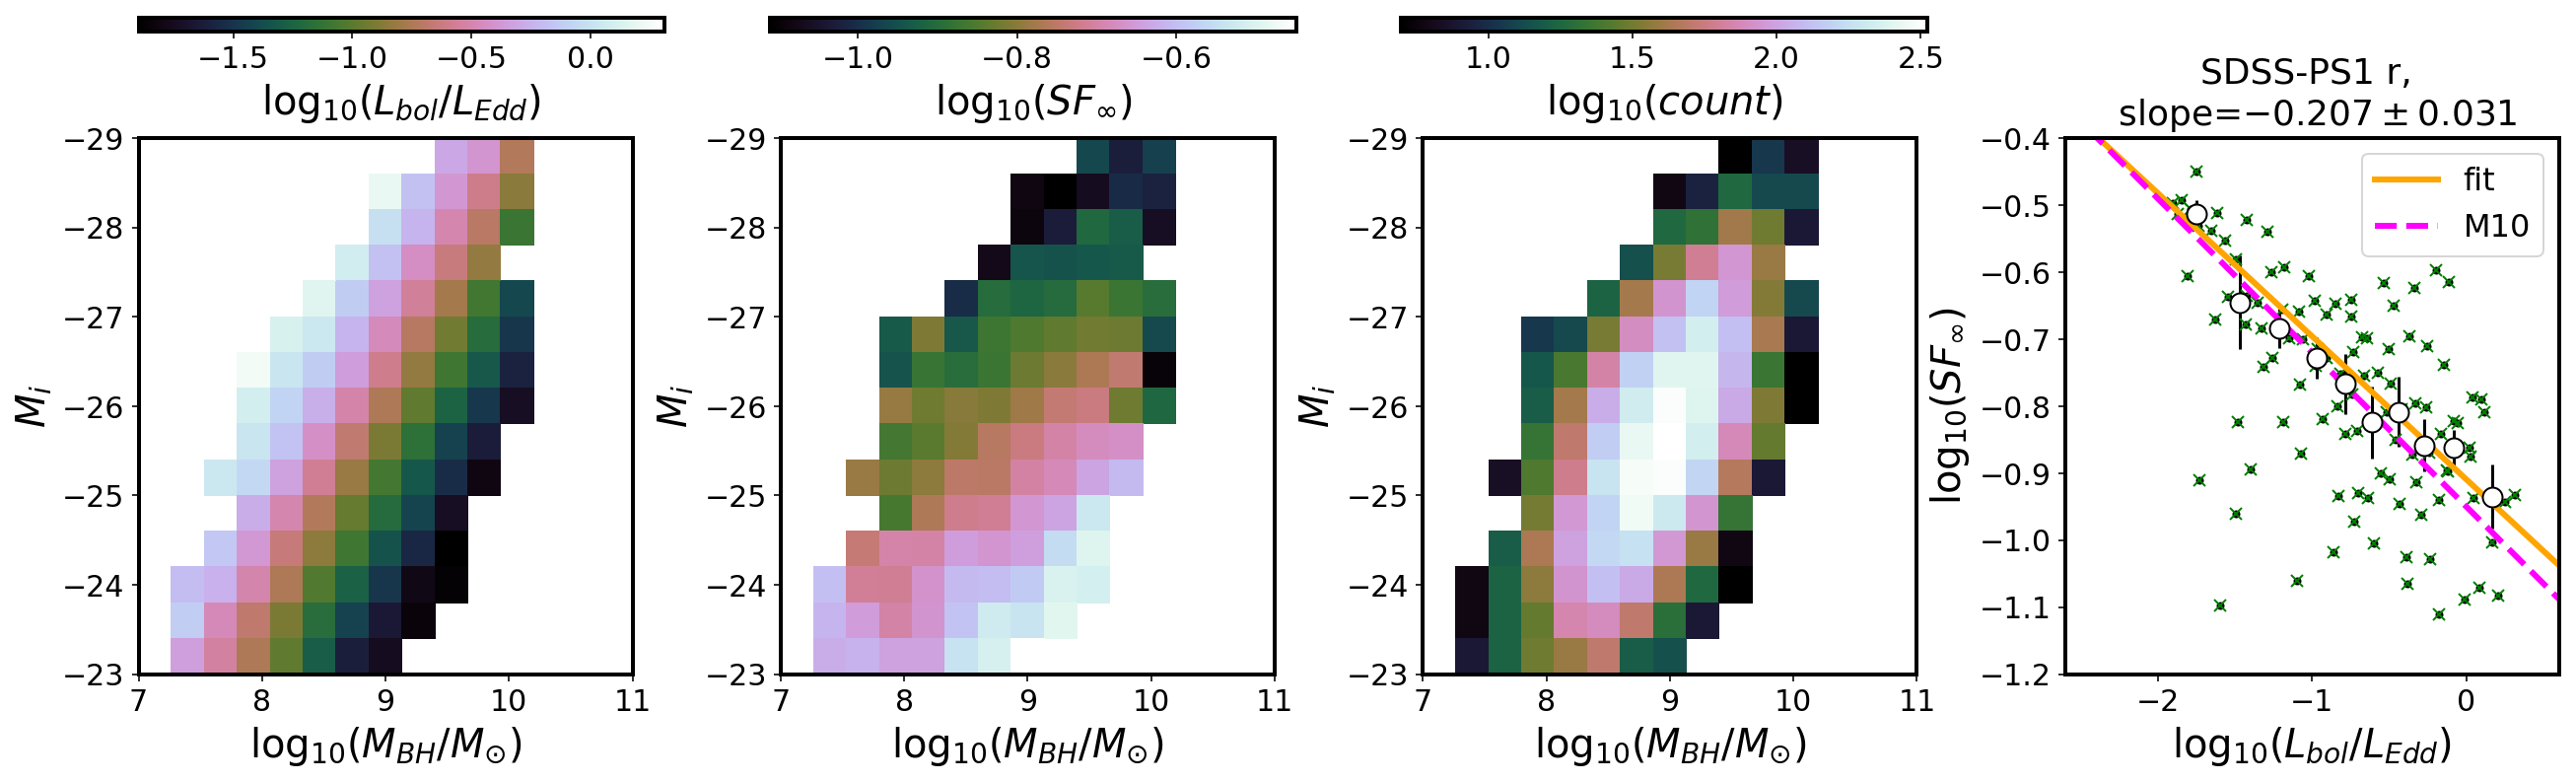

In [12]:
#data_ = Table.read('../code/s82drw_ugriz_shen2011_shen2008.txt', format='ascii')
#data_ = Table.read("../code2/190606_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt",
#                 format='ascii')
data_ = Table.read("../code2/190807_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt",
                 format='ascii')

make_fEdd_sfInf_plot(data_,source = 'celerite', seg = 'sdss-ps1', remove_lowN=True, 
                     Nmin = 5 , offset = -0.95, uselinmix =  True, 
                    useTLS=False)